In [308]:
import pandas as pd

In [309]:
e='econedu.csv'
ed=pd.read_csv(e)

In [310]:
ed1=ed[['Year','Median Household Income','Unemployment Rate']]

In [311]:
cpov= 'EconomyChild_Poverty.csv'
ec=pd.read_csv(cpov)

In [312]:
ec['Year']=pd.to_datetime(ec['Year']).dt.year

In [313]:
ehose='EconomyHousing_Affordability.csv'
eh=pd.read_csv(ehose)

In [314]:
eh['Year']=pd.to_datetime(eh['Year']).dt.year

In [315]:
grace='gender_race.csv'
g=pd.read_csv(grace)

In [316]:
g1=g[['School Year Ending','Gender','Race/Ethnicity','Cohort Students','Cohort Graduates','Cohort Graduation Rate']]

In [317]:
g1['School Year Ending']=pd.to_datetime(g1['School Year Ending']).dt.year

C:\Users\Kevin Bryson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [318]:
g2=g1.rename(columns={'School Year Ending':'Year'})

In [319]:
hi='Health_Insurance.csv'
h=pd.read_csv(hi)

In [320]:
h['YEAR']=pd.to_datetime(h['YEAR']).dt.year

In [321]:
h.rename(columns={'YEAR':'Year'}, inplace='True')

In [322]:
from functools import reduce

In [323]:
dfs= [ed1, ec, eh, g2,h]
matrix= reduce(lambda left, right: pd.merge(left, right, on='Year'), dfs)

In [324]:
matrix1=matrix.rename(columns={'USA_x':'USA_poverty','CA_x':'CA_poverty','SBC_x':'SBC_poverty','USA_y':'USA_house','CA_y':'CA_house','SBC_y':'SBC_house'})

In [325]:
m2=matrix1.rename(columns={'US':'US_ins','CA':'CA_ins','SB':'SB_ins'})

In [326]:
m2['USA_poverty']=m2['USA_poverty'].replace('%','', regex=True).astype(float)
m2['CA_poverty']=m2['CA_poverty'].replace('%','', regex=True).astype(float)
m2['SBC_poverty']=m2['SBC_poverty'].replace('%','', regex=True).astype(float)
m2['USA_house']=m2['USA_house'].replace('%','', regex=True).astype(float)
m2['CA_house']=m2['CA_house'].replace('%','', regex=True).astype(float)
m2['SBC_house']=m2['SBC_house'].replace('%','', regex=True).astype(float)
m2['US_ins']=m2['US_ins'].replace('%','', regex=True).astype(float)
m2['CA_ins']=m2['CA_ins'].replace('%','', regex=True).astype(float)
m2['SB_ins']=m2['SB_ins'].replace('%','', regex=True).astype(float)

In [327]:
m2.rename(columns={'Gender_x':'Male', 'Race/Ethnicity_x':'Ethnicity Male','Ethnic Grad Rate_x':'Ethnic Grad Rate Male','Gender_y':'Female','Race/Ethnicity_y':'Ethnicity Female','Ethnic Grad Rate_y':'Ethnic Grad Rate Female'}, inplace=True)

In [328]:
m3=m2[['Year','Median Household Income','Unemployment Rate','SBC_poverty','SBC_house','Gender','Race/Ethnicity','Cohort Graduation Rate','SB_ins']]

In [329]:
dummy=pd.get_dummies(m3[['Gender','Race/Ethnicity']])
m4=pd.concat([m3, dummy], axis=1)

In [330]:
from sklearn.preprocessing import LabelEncoder

In [331]:
le=LabelEncoder()
m4['Gender']=le.fit_transform(m4['Gender'])


In [332]:
m4.rename(columns={'Race/Ethnicity_African American, Not Hispanic':'African American','Race/Ethnicity_All Students':'All Students','Race/Ethnicity_American Indian or Alaska Native, Not Hispanic':'American Indian or Alaska Native','Race/Ethnicity_Asian, Not Hispanic':'Asian','Race/Ethnicity_Filipino, Not Hispanic':'Filipino','Race/Ethnicity_Hispanic or Latino of Any Race':'Hispanic or Latino','Race/Ethnicity_Not Reported':'Not Reported','Race/Ethnicity_Pacific Islander, Not Hispanic':'Pacific Islander','Race/Ethnicity_Two or More Races, Not Hispanic':'Two or More Races','Race/Ethnicity_White, Not Hispanic':'White'}, inplace=True)

In [333]:
m5=m4.drop(['Race/Ethnicity'], axis=1)
m5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 209
Data columns (total 21 columns):
Year                                210 non-null int64
Median Household Income             210 non-null int64
Unemployment Rate                   210 non-null float64
SBC_poverty                         210 non-null float64
SBC_house                           210 non-null float64
Gender                              210 non-null int64
Cohort Graduation Rate              210 non-null float64
SB_ins                              210 non-null float64
Gender_All Students                 210 non-null uint8
Gender_Female                       210 non-null uint8
Gender_Male                         210 non-null uint8
African American                    210 non-null uint8
All Students                        210 non-null uint8
American Indian or Alaska Native    210 non-null uint8
Asian                               210 non-null uint8
Filipino                            210 non-null uint8
Hispa

In [334]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

In [335]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

correlation= m5.corr(method='spearman')
columns=correlation.nlargest(10, 'Cohort Graduation Rate').index
columns
     

Index(['Cohort Graduation Rate', 'Filipino', 'Asian', 'Gender_Female', 'Year',
       'SB_ins', 'SBC_poverty', 'White', 'Two or More Races',
       'Median Household Income'],
      dtype='object')

In [336]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix

In [337]:
X=m5[columns]
X=m5.drop('Cohort Graduation Rate', axis=1)
y=m5['Cohort Graduation Rate']


X_train, X_test, y_train, y_test=train_test_split(X, y.values, test_size=0.20, random_state=42)

pipe_lr= Pipeline([('Scaler', StandardScaler()),('method', LinearRegression())])
pipe_ls= Pipeline([('Scaler', StandardScaler()),('method', Lasso())])

parameters= [
    {
        'method':[LinearRegression()],
            'method__fit_intercept':[True,False]
    },
    {
        'method':[Lasso()],
             'method__alpha':[0.05,0.1,0.5,1.0,1.5]
    },
]


pipe_lr.fit(X_train, y_train)
pipe_ls.fit(X_train, y_train)

lr_pred = pipe_lr.predict(X_test)
ls_pred = pipe_ls.predict(X_test)



gridlr= GridSearchCV(pipe_lr, param_grid=parameters, cv=3, scoring='r2')

gridlr.fit(X_train, y_train)

print('Best: %f using %s' %(gridlr.best_score_, gridlr.best_params_))

gridls= GridSearchCV(pipe_ls, param_grid= parameters, cv=3, scoring ='r2')

gridls.fit(X_train, y_train)

print('Best: %f using %s' %(gridls.best_score_, gridls.best_params_))

Best: 0.893124 using {'method': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 'method__fit_intercept': True}
Best: 0.893124 using {'method': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 'method__fit_intercept': True}


In [338]:
from sklearn.model_selection import learning_curve

In [339]:
train_sizes, train_scores, valid_scores= learning_curve(LinearRegression(fit_intercept=True), X, y, train_sizes=[20,30,40,50,100], cv=3)
train_sizes

array([ 20,  30,  40,  50, 100])

In [340]:
train_scores

array([[0.95957324, 0.97314612, 0.97314612],
       [0.96060955, 0.97136164, 0.97136164],
       [0.9233269 , 0.97310094, 0.97310094],
       [0.9290736 , 0.96279483, 0.96279483],
       [0.8938392 , 0.93477648, 0.95453767]])

In [341]:
valid_scores

array([[ 8.25455427e-01, -1.20748428e+22, -1.20255705e+22],
       [ 8.35648280e-01,  3.92385058e-01,  2.82741310e-01],
       [ 8.44855487e-01,  4.13779732e-01,  2.96460606e-01],
       [ 8.56909366e-01,  7.86134251e-01,  4.06452081e-01],
       [ 8.94871526e-01,  7.80872306e-01, -2.18374119e+00]])

In [342]:
import seaborn as sns
from scipy.stats import spearmanr
from scipy import stats
import matplotlib.pyplot as plt

In [343]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Gender_Male'])

SpearmanrResult(correlation=-0.36051922726257835, pvalue=7.65442864637294e-08)

In [344]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['SB_ins'])

SpearmanrResult(correlation=0.24374880047615838, pvalue=0.0003637232844371276)

In [345]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['Gender_Female'])

SpearmanrResult(correlation=0.37970916867882387, pvalue=1.3159564892228586e-08)

In [346]:
stats.spearmanr(m5['Cohort Graduation Rate'], m5['SBC_poverty'])

SpearmanrResult(correlation=0.22430666734793245, pvalue=0.001064438918796859)

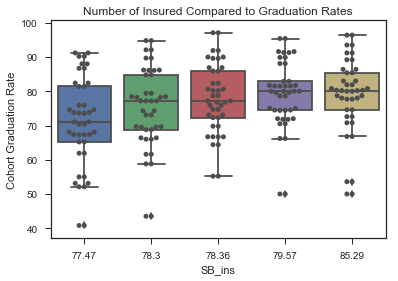

In [347]:
sns.set(style='ticks')
sns.boxplot(y='Cohort Graduation Rate', x='SB_ins',data=m5)
sns.swarmplot(y='Cohort Graduation Rate', x='SB_ins', data=m5, size=5, color='.3', linewidth=0)
plt.title('Number of Insured Compared to Graduation Rates')
plt.show()

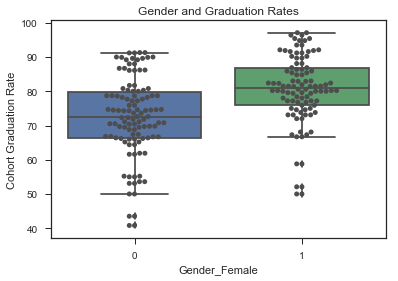

In [348]:
sns.set(style='ticks')

sns.boxplot(x='Gender_Female', y='Cohort Graduation Rate', data=m5)

sns.swarmplot(x='Gender_Female', y='Cohort Graduation Rate', data=m5, size=5, color='.3', linewidth=0)

plt.title('Gender and Graduation Rates')

plt.show()

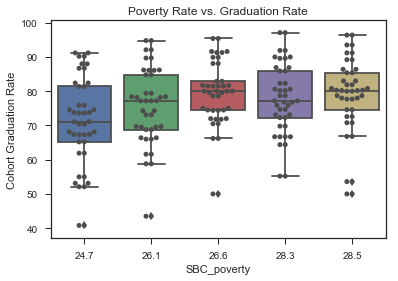

In [349]:
sns.set(style='ticks')

sns.boxplot(x='SBC_poverty', y='Cohort Graduation Rate', data=m5)

sns.swarmplot(x='SBC_poverty', y='Cohort Graduation Rate', data=m5, size=5, color='.3', linewidth=0)

plt.title('Poverty Rate vs. Graduation Rate')

plt.show()
